In [ ]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import CustFun
import numpy as np 


In [3]:
df = pd.read_csv('./preprocess/worldGame.csv',index_col=0)

nor_cols = [ 'old', 'bwt', 'sq', 'bp', 'dl', 'total', 'ipf_gl_c']
cat_cols = ['year','team', 'wc','gender','rank']

df = df[nor_cols+cat_cols]
for f in cat_cols:
    df[f] = df[f].astype('category')

### 觀察資料集是否有異常資料

<h>1.比賽中57歲可能會是outlier</h>

<h>2.第四量集為無限量級，體重可能會有outlier</h>

In [4]:
df.describe()

,old,bwt,sq,bp,dl,total,ipf_gl_c
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,32.175000,81.493875,282.127500,189.625000,257.595000,729.347500,0.168999
std,7.188084,27.815755,81.482489,69.878148,66.523346,211.103736,0.023195
min,15.000000,43.500000,130.000000,67.500000,120.000000,332.500000,0.133400
25%,27.000000,60.012500,215.000000,131.875000,200.000000,544.375000,0.150275
50%,31.000000,74.675000,271.250000,180.000000,255.000000,720.000000,0.165400
75%,37.000000,95.325000,352.500000,242.500000,315.000000,920.000000,0.185750
max,57.000000,190.250000,482.500000,360.000000,420.000000,1177.500000,0.232800


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   old       400 non-null    int64   
 1   bwt       400 non-null    float64 
 2   sq        400 non-null    float64 
 3   bp        400 non-null    float64 
 4   dl        400 non-null    float64 
 5   total     400 non-null    float64 
 6   ipf_gl_c  400 non-null    float64 
 7   year      400 non-null    category
 8   team      400 non-null    category
 9   wc        400 non-null    category
 10  gender    400 non-null    category
 11  rank      400 non-null    category
dtypes: category(5), float64(6), int64(1)
memory usage: 29.2 KB


### 檢查異常值

,old,bwt,sq,bp,dl,total,ipf_gl_c
異常值數量,4,11,0,0,0,0,0


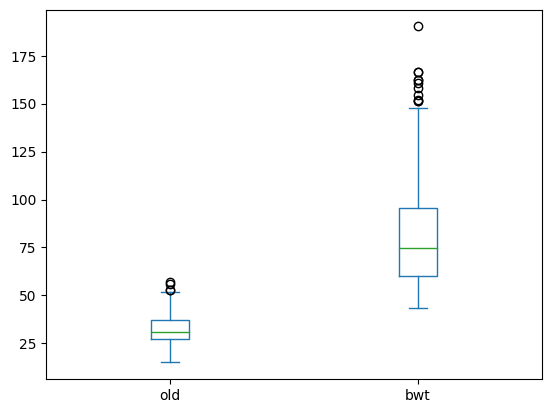

In [6]:
#利用四分位距檢查
df[['old','bwt']].plot.box()
pd.DataFrame(data={f:[len(CustFun.getOutlierIdx(df,f))] for f in nor_cols},index=['異常值數量'])

### 透過變異數分析和Pearson係數 進一步觀察old、bwt

<h>old：與rank有顯著性差異：保留</h>

<h>btw:與連續型變數有強烈線性關係：保留並做分布轉換</h>

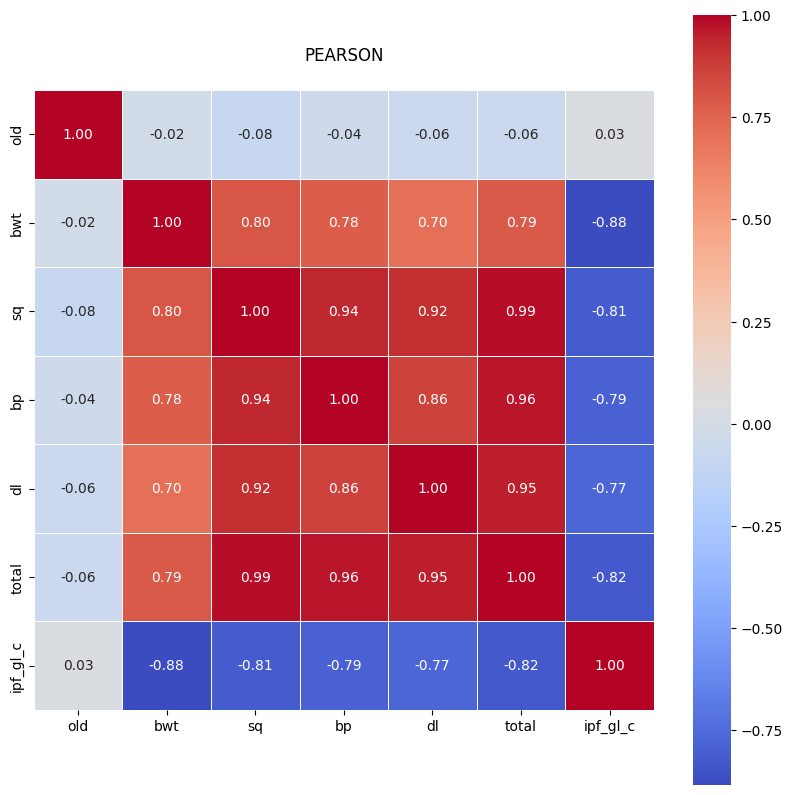

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df[nor_cols].corr(method='pearson'),cmap='coolwarm',annot=True,fmt='0.2f', linewidth=.5,ax=ax).set_title("PEARSON\n")
ax.set_aspect("equal")

In [8]:
from scipy.stats import f_oneway

In [9]:
def old_oneway(data:pd.DataFrame,terget_feature:list[str]):
    df_tmp = data.copy()
    df_tmp['old'] = pd.qcut(data['old'],q=[0,0.25,0.5,0.75,1],labels=[0,1,2,3]).to_list()
    dic={'feature':[],'p_value':[],'f_value':[]}
    for fea in terget_feature:
        f,p_value = f_oneway(*[df_tmp.loc[df_tmp['old']==i][fea].to_list() for i in df_tmp['old'].unique()])
        dic['feature']+=[fea]
        dic['p_value']+=[p_value]
        dic['f_value']+=[f]
    
    return pd.DataFrame(data=dic)
old_oneway(df,['bwt', 'sq', 'bp', 'dl', 'ipf_gl_c'])

,feature,p_value,f_value
0,bwt,0.774109,0.370815
1,sq,0.126859,1.913123
2,bp,0.241002,1.404528
3,dl,0.206729,1.527899
4,ipf_gl_c,0.397532,0.989759


In [10]:
CustFun.n_way_anova(df,['wc','gender','year'],['old'])

,type,wc,gender,year
old,p_value,0.783036,0.513993,0.438209
,f_value,0.358473,0.426709,0.966302


In [11]:
CustFun.n_way_anova(df,['rank','year','wc'],['old'])

,type,rank,year,wc
old,p_value,0.000590,0.629505,0.760828
,f_value,3.066046,0.692346,0.389226


### 檢查wc、gender、year、rank與其他連續型變數的間的關聯性
<h>wc,gender,year:都有顯著性差異：保留</h>

<h>rank:部分變數有顯著性差異：保留</h>

In [12]:
CustFun.n_way_anova(df,['wc','gender','year'],['old', 'bwt', 'sq', 'bp', 'dl', 'total','ipf_gl_c'])

,type,wc,gender,year
old,p_value,7.830364e-01,5.139929e-01,4.382091e-01
,f_value,3.584730e-01,4.267094e-01,9.663017e-01
bwt,p_value,8.151238e-128,7.034206e-46,1.559471e-10
,f_value,4.609500e+02,2.653418e+02,1.167947e+01
sq,p_value,5.969822e-64,2.467996e-90,4.155247e-40
,f_value,1.477259e+02,7.164299e+02,5.021783e+01
bp,p_value,1.321456e-55,6.346138e-77,3.895875e-43
,f_value,1.216028e+02,5.546304e+02,5.493940e+01
dl,p_value,4.869706e-48,2.179937e-89,1.648734e-35
,f_value,1.000365e+02,7.041550e+02,4.335655e+01


In [13]:
CustFun.n_way_anova(df,['rank','year','wc'],['old','bwt', 'sq', 'bp', 'dl', 'total','ipf_gl_c'])

,type,rank,year,wc
old,p_value,0.000590,6.295052e-01,7.608285e-01
,f_value,3.066046,6.923456e-01,3.892261e-01
bwt,p_value,0.154872,1.651976e-06,2.966869e-95
,f_value,1.434625,7.258211e+00,2.770031e+02
sq,p_value,0.000416,2.554320e-18,2.333601e-29
,f_value,3.157898,2.072813e+01,5.458265e+01
bp,p_value,0.000657,1.860055e-22,4.794214e-28
,f_value,3.037971,2.583480e+01,5.170448e+01
dl,p_value,0.014581,3.287698e-15,8.195206e-21
,f_value,2.185940,1.703829e+01,3.662719e+01


In [14]:
CustFun.n_way_anova(df,['team','wc','gender'],['old','bwt', 'sq', 'bp', 'dl', 'total','ipf_gl_c'])

,type,team,wc,gender
old,p_value,2.057749e-10,5.385609e-01,7.728853e-01
,f_value,3.507784e+00,7.233782e-01,8.341846e-02
bwt,p_value,3.409428e-05,2.687096e-99,1.295779e-36
,f_value,2.311903e+00,3.121848e+02,2.019219e+02
sq,p_value,1.179233e-03,3.961544e-37,1.292144e-56
,f_value,1.920103e+00,7.377433e+01,3.659947e+02
bp,p_value,2.396562e-02,1.642406e-30,5.617819e-45
,f_value,1.540199e+00,5.790968e+01,2.653798e+02
dl,p_value,4.608532e-03,7.917626e-30,2.647255e-59
,f_value,1.756314e+00,5.634728e+01,3.914784e+02


#### 對(bwt)體重進行分布轉換

不確定old剩下那筆資料是否會對預測產生影響，先不刪除


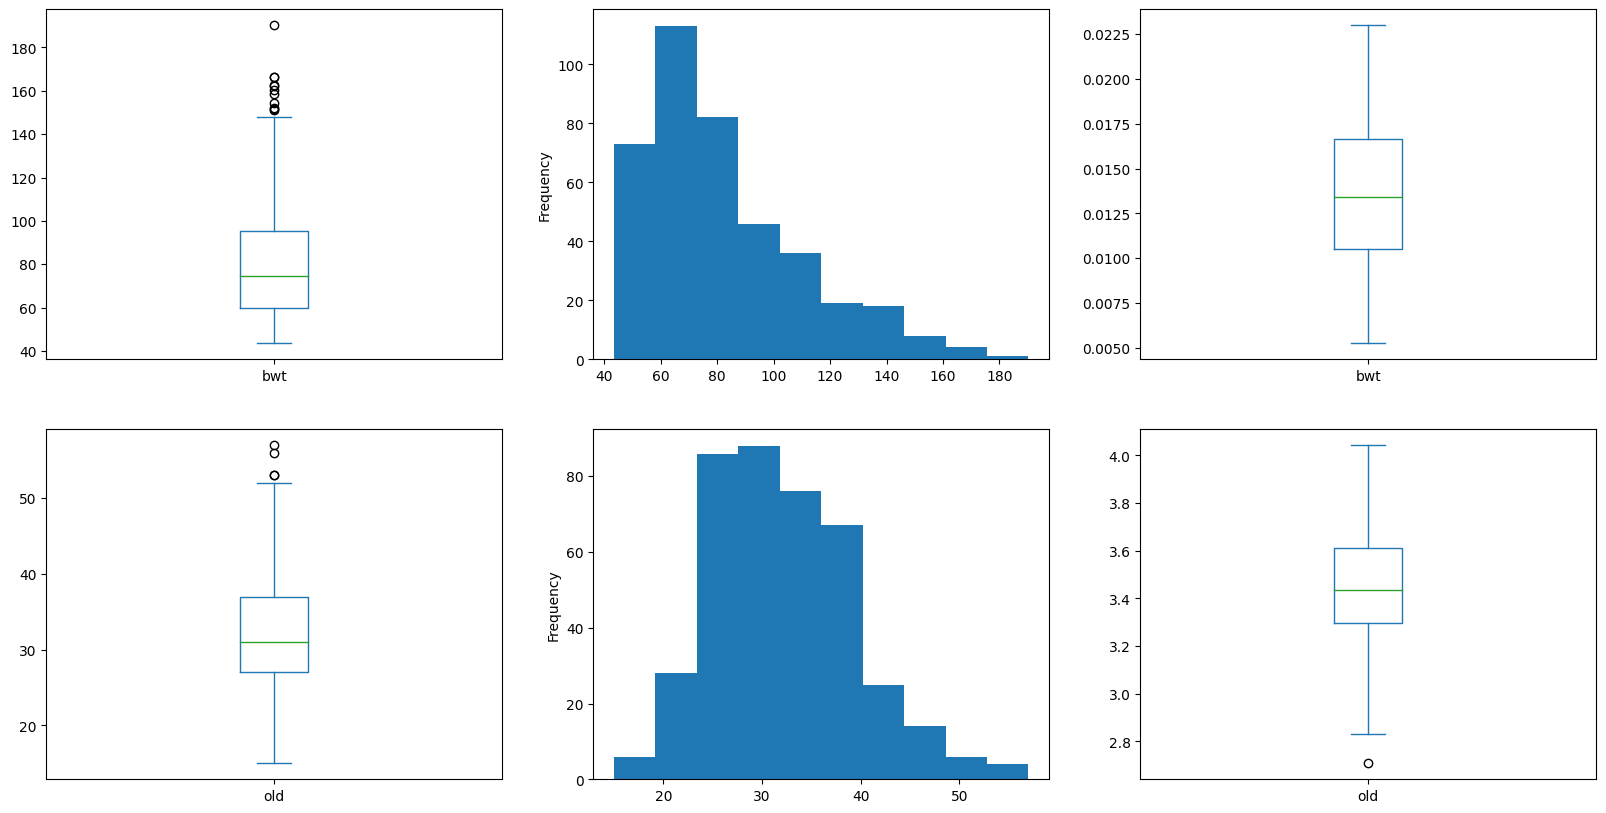

,old,bwt,sq,bp,dl,total,ipf_gl_c
處理前,4,11,0,0,0,0,0
處理後,1,0,0,0,0,0,0


In [15]:
#利用四分位距檢查
df_a = pd.DataFrame(data={f:[len(CustFun.getOutlierIdx(df,f))] for f in nor_cols})

#作適當的比例轉換，盡量保持outlier
df_after = df.copy()
df_after['bwt'] = 1/df_after['bwt']
df_after['old'] = np.log(df_after['old'])

df_b = pd.DataFrame(data={f:[len(CustFun.getOutlierIdx(df_after,f))] for f in nor_cols})
df_a = pd.concat([df_a,df_b])
df_a.index =['處理前','處理後']

print("不確定old剩下那筆資料是否會對預測產生影響，先不刪除")
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10))
df['bwt'].plot.box(ax=axes[0,0])
df['bwt'].plot.hist(ax=axes[0,1])
(1/df['bwt']).plot.box(ax=axes[0,2])
df['old'].plot.box(ax=axes[1,0])
df['old'].plot.hist(ax=axes[1,1])
(np.log(df['old'])).plot.box(ax=axes[1,2])
plt.show()

df = df_after.copy()
df.index = [i for i in range(len(df))]
df_a

In [18]:
df.to_csv('./analyze/worldGame.csv')